In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Residual

We need to have a way to tell when to stop smoothing.

If we know the analytic solution, then we can just compare to that, and keep iterating until the error is small, but that kinda defeats the purpose.
Instead, we can measure how well we satisfy the discrete equation&mdash;this is called the *residual*.

$$r_i \equiv f_i - \frac{\phi^{(k)}_{i+1} - 2 \phi^{(k)}_i + \phi_{i-1}^{(k)}}{\Delta x^2}$$

We still need something to compare to, so we define the *source norm*, $\| f \|$, and we will pick a tolerance $\epsilon$ and iterate until:

$$\| r \| < \epsilon \| f \|$$

For the special case of a homogeneous source ($f = 0$), then we will iterate until

$$\| r \| < \epsilon$$

We will use the L2 norm:

$$\| e \|_2 \equiv \left ( \Delta x \sum_i |e_i|^2 \right )^{1/2}$$

Let's update our grid class to include a norm and residual function:

In [2]:
class Grid:
    def __init__(self, nx, ng=1, xmin=0, xmax=1,
                 bc_left_type="dirichlet", bc_left_val=0.0,
                 bc_right_type="dirichlet", bc_right_val=0.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx
        
        self.bc_left_type = bc_left_type
        self.bc_left_val = bc_left_val
        
        self.bc_right_type = bc_right_type
        self.bc_right_val = bc_right_val
        
        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = self.scratch_array()
        self.f = self.scratch_array()
        
    def scratch_array(self):
        """return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def norm(self, e):
        """compute the L2 norm of e that lives on our grid"""
        return np.sqrt(self.dx * np.sum(e[self.ilo:self.ihi+1]**2))
    
    def residual_norm(self):
        """compute the residual norm"""
        r = self.scratch_array()
        r[self.ilo:self.ihi+1] = self.f[self.ilo:self.ihi+1] - (self.phi[self.ilo+1:self.ihi+2] -
                                                                2 * self.phi[self.ilo:self.ihi+1] +
                                                                self.phi[self.ilo-1:self.ihi]) / self.dx**2
        return self.norm(r)
    
    def source_norm(self):
        """compute the source norm"""
        return self.norm(self.f)
    
    def fill_bcs(self):
        """fill the boundary conditions on phi"""
        
        # we only deal with a single ghost cell here
        
        # left
        if self.bc_left_type.lower() == "dirichlet":
            self.phi[self.ilo-1] = 2 * self.bc_left_val - self.phi[self.ilo]
        elif self.bc_left_type.lower() == "neumann":
            self.phi[self.ilo-1] = self.phi[self.ilo] - self.dx * self.bc_left_val
        else:
            raise ValueError("invalid bc_left_type")
            
        # right
        if self.bc_right_type.lower() == "dirichlet":
            self.phi[self.ihi+1] = 2 * self.bc_right_val - self.phi[self.ihi]
        elif self.bc_right_type.lower() == "neumann":
            self.phi[self.ihi+1] = self.phi[self.ihi] - self.dx * self.bc_right_val
        else:
            raise ValueError("invalid bc_right_type")
        

Now we'll write a relaxation function that does smoothing until either a maximum number of iterations is taken or we reach a desired tolerance.  If the tolerance is set to `None`, then the routine will take the full amount of iterations.

In [3]:
class TooManyIterations(Exception):
    pass

def relax(g, tol=1.e-8, max_iters=200000, analytic=None):
    
    iter = 0
    fnorm = g.source_norm()
    if fnorm == 0.0:
        fnorm = tol
        
    r = g.residual_norm()
    
    res_norm = []
    true_norm = []
    
    if tol is None:
        test = iter < max_iters
    else:
        test = iter < max_iters and r > tol * fnorm

    g.fill_bcs()

    while test:
        g.phi[g.ilo:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo:g.ihi+1:2] +
                                        g.phi[g.ilo+1:g.ihi+2:2] + g.phi[g.ilo-1:g.ihi:2])
    
        g.fill_bcs()

        g.phi[g.ilo+1:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo+1:g.ihi+1:2] +
                                          g.phi[g.ilo+2:g.ihi+2:2] + g.phi[g.ilo:g.ihi:2])
        
        g.fill_bcs()
        
        r = g.residual_norm()
        res_norm.append(r)
        
        if analytic is not None:
            true_norm.append(g.norm(g.phi - analytic(g.x)))
        
        iter += 1
        
        if tol is None:
            test = iter < max_iters
        else:
            test = iter < max_iters and r > tol * fnorm

    if tol is not None and iter >= max_iters:
        raise TooManyIterations(f"too many iterations, niter = {iter}")
        
    return res_norm, true_norm

## Residual vs. Truncation Error

Now we'll look at how the residual error compares to the truncation error of our discretization.  We'll take a fixed number of iterations for our same model problem,

$$\phi^{\prime\prime} = \sin(x)$$

on $[0, 1]$ with homogeneous Dirichlet BCs.

In [4]:
def analytic(x):
    return -np.sin(x) + x * np.sin(1.0)

def f(x):
    return np.sin(x)

nx = 16, true error = 0.0002489743563076079
nx = 32, true error = 6.22480653738797e-05
nx = 64, true error = 1.5562295551083177e-05


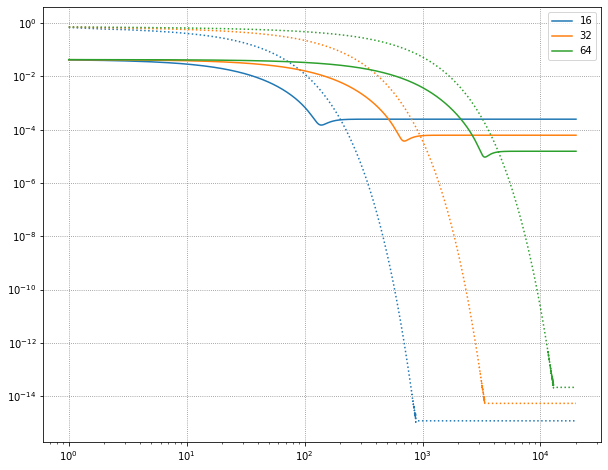

In [5]:
fig = plt.figure()
fig.set_size_inches(10, 8)

ax = fig.add_subplot(111)

for i, nx in enumerate([16, 32, 64]):
    g = Grid(nx)
    g.f[:] = f(g.x)

    res_norm, true_norm = relax(g, tol=None, max_iters=20000, analytic=analytic)
    n = np.arange(len(res_norm)) + 1
    
    ax.loglog(n, true_norm, label=f"{nx}", color=f"C{i}")
    ax.loglog(n, res_norm, ls=":", color=f"C{i}")
    
    print(f"nx = {nx}, true error = {true_norm[-1]}")
    
ax.legend()
ax.grid(ls=":", color="0.5")

Look at what this shows us:
    
* The truncation error (solid line) stalls at a much higher value than the residual (dotted).  

* The truncation error converges second order with the number of zones (look at the numbers printed during the run)

* As we increase the number of zones, we need more iterations until the residual drops to machine roundoff

* The residual error eventually reaches roundoff&mdash;this indicates that we satisfy the discrete equation "exactly"

<div class="alert alert-block alert-info">

**Exercise:**
    
Solve the problem 
    
$$\phi^{\prime\prime} = -4\pi^2 \cos(2\pi x)$$
    
on $[0, 1]$ with homogeneous Neumann boundary conditions.
    
</div>